In [319]:
import gc

In [79]:
import pandas as pd

df = pd.read_csv('eCommerceRatings_wHeader.csv')

In [3]:
df.head()

,UserId,ProductId,Rating,Timestamp
0,B01FHDYGQ8,A0010876CNE3ILIM9HV0,5,1476230400
1,B01B18T01Y,A001170867ZBE9FORRQL,5,1487203200
2,B01FCW88D6,A001170867ZBE9FORRQL,5,1476576000
3,B00TZ8XK1E,A0028738FYF1SKPPC7B1,5,1440028800
4,B018H0EJI8,A0045356A23634W7RI4M,3,1463961600


In [81]:
df.columns = ['userId', 'productId', 'rating', 'timestamp']

In [5]:
df.rating.value_counts()

rating
5    229549
4     52687
1     39261
3     29555
2     20293
Name: count, dtype: int64

<Axes: >

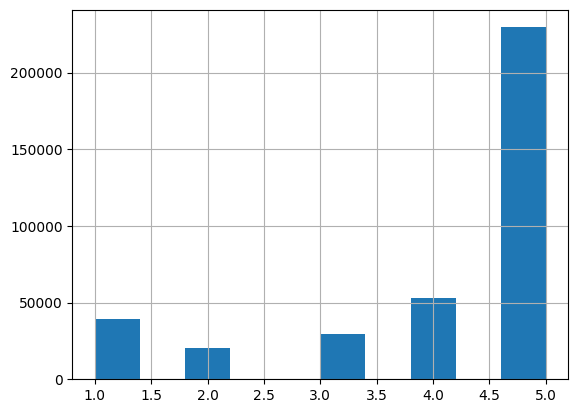

In [6]:
df.rating.hist()

In [7]:
import os
if not os.path.isdir('test'):
    os.mkdir("test")

if not os.path.isdir('train'):
    os.mkdir("train")

In [8]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
X = df[['userId', 'productId']]
Y = df['rating']
i = 0
for train_index, test_index in skf.split(X, Y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]
    pd.concat([X_train, y_train], axis=1).to_csv(f"train/{i}.csv")
    pd.concat([X_test, y_test], axis=1).to_csv(f"test/{i}.csv")
    i += 1

(334210, 4)
(37135, 4)


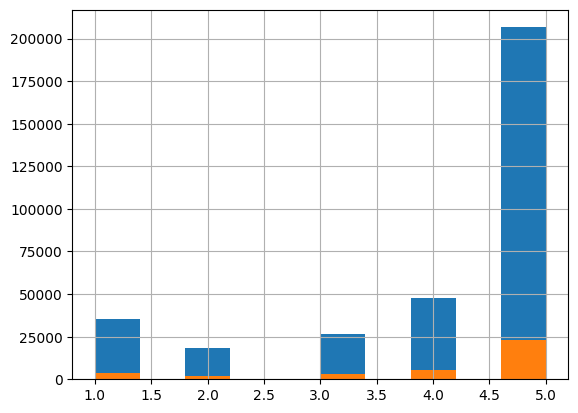

In [9]:
pd.read_csv('train/0.csv').rating.hist()
print(pd.read_csv('train/0.csv').shape)
pd.read_csv('test/0.csv').rating.hist()
print(pd.read_csv('test/0.csv').shape)

In [10]:
df.nunique()

userId        32586
productId    324038
rating            5
timestamp      5288
dtype: int64

### Kk some thoughts:
Does time matter? Time only shows us at what point a user rated, not when the user bought the product (though it may be safe to say within a couple weeks given how Amazon has their system setup). 

If time matters, Markov Chain -> TimeSVD++? Autoencoder?

Otherwise starting simple with collab filtering (user / item / hybrid splits)

user will be much smaller than product, product cosine sim is 1TB in data alone (325k^2 * 8byte (float))

However, instead of doing that, I have the list of products im looking at that are most similar (in fact, just the 5), so maybe I can get away with a 325*5*8 map, because that's only 13Mb.

Other ideas:
- Neural collab filtering
- SVD / ALS / PCA
- KNN / K-means / GaussianMixture
- Apriori
     - Requires data conversion.
- Page Rank
    - Graph algorithms, weights based on number of times bought by a user + weights of reviews. 1 - 5 translated to -2 - +2?

Let's start simple.

# Collaborative Filtering

In [1]:
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import numpy as np

In [152]:
# user_item_rating_matrix = df.pivot_table(index='userId', columns='productId', values='rating').fillna(0).astype(int)
# user_item_rating_matrix.to_parquet("user_item_matrix.parquet", engine='fastparquet')

In [6]:
user_item_rating_matrix = pd.read_parquet("user_item_matrix.parquet").astype(int)
product_index = user_item_rating_matrix.columns
user_index = user_item_rating_matrix.index


In [9]:
user_item_rating_matrix.columns.get_loc('A696ZTE6VBU4U')

253570

In [13]:
### FOR Q1
from scipy.sparse import csr_matrix, save_npz, load_npz
save_npz("csr_matrix.npz", csr_matrix(user_item_rating_matrix))

### FOR Q2
for idx in [
    'A696ZTE6VBU4U',
    'A6CEOJ5ISIGRB',
    'A2PLGB52VCSYHG',
    'A2PUZMHH482FU7',
    'A2Q2V2KMKOQDI0',
]:
    x = np.zeros(user_item_rating_matrix.shape[1])
    x[user_item_rating_matrix.columns.get_loc(idx)] = 5
    user_item_rating_matrix.loc[idx+"_new_user"] = x

from scipy.sparse import csr_matrix, save_npz, load_npz
save_npz("csr_matrix_few_users.npz", csr_matrix(user_item_rating_matrix))

In [16]:
## user-user cosine similarity, in dumb format for C
def export_csr_to_txt(file_name, output_file):
    sparse_matrix = load_npz(file_name)

    # Extract CSR components
    values = sparse_matrix.data
    col_index = sparse_matrix.indices
    row_ptr = sparse_matrix.indptr
    rows, cols = sparse_matrix.shape
    
    # Save CSR components to a text file
    with open(output_file, 'w') as f:
        # First, write the number of rows, columns, and number of non-zero entries
        f.write(f"{rows} {cols} {len(values)}\n")
        
        # Write non-zero values
        for value in values:
            f.write(f"{value} ")
        f.write("\n")
        
        # Write column indices
        for idx in col_index:
            f.write(f"{idx} ")
        f.write("\n")
        
        # Write row pointer
        for ptr in row_ptr:
            f.write(f"{ptr} ")
        f.write("\n")

export_csr_to_txt('csr_matrix_few_users.npz','csr_matrix_new_users.txt')
export_csr_to_txt('csr_matrix.npz','csr_matrix.txt')


In [2]:
import subprocess
subprocess.run(["gcc", "cosine_sim.c", "-o", "sim_calc"])
subprocess.run(["chmod", "777", "sim_calc"])

CompletedProcess(args=['chmod', '777', 'sim_calc'], returncode=0)

In [3]:
#### FOR Q1
subprocess.run(["./sim_calc", "csr_matrix.txt", "cosine_similarity_matrix_for_users.txt"])

reading in files
read in the matrix!!! time to jack in
cosine similarity matrix has been saved to 'cosine_similarity_matrix_for_users.txt'.


CompletedProcess(args=['./sim_calc', 'csr_matrix.txt', 'cosine_similarity_matrix_for_users.txt'], returncode=0)

In [4]:
#### FOR Q2
subprocess.run(["./sim_calc", "csr_matrix_new_users.txt", "cosine_similarity_matrix_new_users.txt"])

reading in files
read in the matrix!!! time to jack in
cosine similarity matrix has been saved to 'cosine_similarity_matrix_new_users.txt'.


CompletedProcess(args=['./sim_calc', 'csr_matrix_new_users.txt', 'cosine_similarity_matrix_new_users.txt'], returncode=0)

In [153]:
import gc

gc.collect() # lotsa trash lol - I used up like 48 gigs of memory just by existing.

3374

# Q2

In [22]:
user_cosine_sim_new_users = pd.read_csv("cosine_similarity_matrix_new_users.txt", sep=" ", header=None)

In [23]:
user_cosine_sim_new_users

,0,1,2,3,4,5,6,7,8,9,...,32582,32583,32584,32585,32586,32587,32588,32589,32590,32591
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32586,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN
32587,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN
32588,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,NaN
32589,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,NaN


In [25]:

product_index = user_item_rating_matrix.columns
user_index = user_item_rating_matrix.index
user_cosine_sim_new_users.index = user_index

In [29]:
user_cosine_sim_new_users = user_cosine_sim_new_users.iloc[:, :-1]

In [30]:
user_cosine_sim_new_users.columns = user_index

In [45]:
def recommend(user_id, user_item_matrix, user_similarity_df):
    # Get similar users to the target user
    similar_users = user_similarity_df[user_id].sort_values(ascending=False)[1:10]
    # print(similar_users)
    # Get products rated by similar users and compute the weighted average of their ratings
    recommendations = pd.DataFrame()
    for similar_user in similar_users.index:
        similar_user_ratings = user_item_matrix.loc[similar_user]
        recommendations = pd.concat([recommendations, similar_user_ratings], axis=1)
    # print(recommendations)
    recommendations = recommendations.mean(axis=1).sort_values(ascending=False)
    
    # Return top N recommended products
    return recommendations


In [ ]:
df

In [125]:
df.groupby('userId')['userId'].value_counts().mean()

11.395844841342909

In [41]:
user_item_rating_matrix.iloc[-5:].index

Index(['A696ZTE6VBU4U_new_user', 'A6CEOJ5ISIGRB_new_user',
       'A2PLGB52VCSYHG_new_user', 'A2PUZMHH482FU7_new_user',
       'A2Q2V2KMKOQDI0_new_user'],
      dtype='object', name='userId')

In [56]:
q2_recs_top_5 = pd.DataFrame()
for user in user_item_rating_matrix.iloc[-5:].index:
    recommended_products = recommend(user_id=user, user_item_matrix=user_item_rating_matrix, user_similarity_df=user_cosine_sim_new_users)
    q2_recs_top_5 = pd.concat([q2_recs_top_5,pd.DataFrame(recommended_products, columns=[user])], axis=1)


In [67]:
q2_recs_based_on_top_10_users = q2_recs_top_5
ds = pd.read_csv('item-item.csv', index_col='productId')

In [74]:
new_df = pd.concat([ds, q2_recs_based_on_top_10_users], axis=1)
for item in ['A696ZTE6VBU4U','A6CEOJ5ISIGRB','A2PLGB52VCSYHG','A2PUZMHH482FU7','A2Q2V2KMKOQDI0']:
    new_df[item+'hybrid_weight_sum'] = 0.7*new_df[item] + 0.3*new_df[item+'_new_user']

In [82]:
dddd = pd.DataFrame(df.productId.value_counts())

In [88]:
new_df['counts'] = dddd.loc[new_df.index]

In [91]:
for x in ds.columns:
    # ds[x][ds[x].values>0].sort_values(ascending=False).plot()
    print("\n")
    print(new_df[[x+'hybrid_weight_sum','counts']].sort_values(by=x+'hybrid_weight_sum',ascending=False)[0:20])
    print("\n")



                A696ZTE6VBU4Uhybrid_weight_sum  counts
A696ZTE6VBU4U                         2.200000       9
AILBHLCU1VM03                         0.620547       3
AFNGCFXDPE55P                         0.523849       6
A3BMSVUXC14JQM                        0.400000       1
A29I4LM8O92CLC                        0.400000       1
A26CC273TKQQUL                        0.400000       1
A3UUDMU2NWGGV8                        0.400000       1
A1B4MVUFA0UXD6                        0.400000       1
A1D1PJTFVNE4EH                        0.400000       1
A3PTNOIZ3R7ELG                        0.400000       1
A2P0UHVIF0TBCI                        0.400000       1
A1VZJLE0DQK1HS                        0.400000       1
A17TLDAJV3L5TD                        0.400000       1
A39BCMWNHH8RI5                        0.400000       1
A2T89PHDRKNOS9                        0.400000       1
A3VOEWK8SSN4XZ                        0.400000       1
A2NJWYQPTT2YG9                        0.400000       1
ATR2B8OA

In [92]:
new_df

,A696ZTE6VBU4U,A6CEOJ5ISIGRB,A2PLGB52VCSYHG,A2PUZMHH482FU7,A2Q2V2KMKOQDI0,A696ZTE6VBU4U_new_user,A6CEOJ5ISIGRB_new_user,A2PLGB52VCSYHG_new_user,A2PUZMHH482FU7_new_user,A2Q2V2KMKOQDI0_new_user,A696ZTE6VBU4Uhybrid_weight_sum,A6CEOJ5ISIGRBhybrid_weight_sum,A2PLGB52VCSYHGhybrid_weight_sum,A2PUZMHH482FU7hybrid_weight_sum,A2Q2V2KMKOQDI0hybrid_weight_sum,counts
A0010876CNE3ILIM9HV0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
A001170867ZBE9FORRQL,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
A0028738FYF1SKPPC7B1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
A0045356A23634W7RI4M,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
A006277084SDH2LTUV6X,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AZZW8CF93X1TC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
AZZWNU4RB5BY1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
AZZXKG9AGRVGU,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
AZZYW4YOE1B6E,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [141]:
dddd = np.log(dddd * pd.DataFrame(df.groupby('productId')['rating'].mean()).loc[list(dddd.index)].to_numpy())

count    0.0
dtype: float64

In [147]:
weighted_by_number_of_customers = new_df*dddd.loc[list(new_df.index)].to_numpy()
weighted_by_number_of_customers.columns = [x+"_weighted_by_num_bought" for x in weighted_by_number_of_customers.columns]

In [148]:
weighted_by_number_of_customers

,A696ZTE6VBU4U_weighted_by_num_bought,A6CEOJ5ISIGRB_weighted_by_num_bought,A2PLGB52VCSYHG_weighted_by_num_bought,A2PUZMHH482FU7_weighted_by_num_bought,A2Q2V2KMKOQDI0_weighted_by_num_bought,A696ZTE6VBU4U_new_user_weighted_by_num_bought,A6CEOJ5ISIGRB_new_user_weighted_by_num_bought,A2PLGB52VCSYHG_new_user_weighted_by_num_bought,A2PUZMHH482FU7_new_user_weighted_by_num_bought,A2Q2V2KMKOQDI0_new_user_weighted_by_num_bought,A696ZTE6VBU4Uhybrid_weight_sum_weighted_by_num_bought,A6CEOJ5ISIGRBhybrid_weight_sum_weighted_by_num_bought,A2PLGB52VCSYHGhybrid_weight_sum_weighted_by_num_bought,A2PUZMHH482FU7hybrid_weight_sum_weighted_by_num_bought,A2Q2V2KMKOQDI0hybrid_weight_sum_weighted_by_num_bought,counts_weighted_by_num_bought
A0010876CNE3ILIM9HV0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.609438
A001170867ZBE9FORRQL,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.605170
A0028738FYF1SKPPC7B1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.609438
A0045356A23634W7RI4M,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.098612
A006277084SDH2LTUV6X,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.609438
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AZZW8CF93X1TC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.609438
AZZWNU4RB5BY1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
AZZXKG9AGRVGU,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.609438
AZZYW4YOE1B6E,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.609438


In [149]:
pre_final_q2 = pd.concat([new_df, weighted_by_number_of_customers[[x for x in weighted_by_number_of_customers.columns if x != 'counts_weighted_by_num_bought']]],axis=1)

In [104]:
from IPython.display import display

In [150]:
for x in ds.columns:
    # ds[x][ds[x].values>0].sort_values(ascending=False).plot()
    print(x)
    display(pre_final_q2[['counts',x,x+'hybrid_weight_sum',x+"_weighted_by_num_bought", x+'hybrid_weight_sum_weighted_by_num_bought']].sort_values(by=x,ascending=False)[0:10])
    print(x+'hybrid_weight_sum')
    display(pre_final_q2[['counts',x,x+'hybrid_weight_sum',x+"_weighted_by_num_bought", x+'hybrid_weight_sum_weighted_by_num_bought']].sort_values(by=x+'hybrid_weight_sum',ascending=False)[0:10])
    print(x+'_weighted_by_num_bought')
    display(pre_final_q2[['counts',x,x+'hybrid_weight_sum',x+"_weighted_by_num_bought", x+'hybrid_weight_sum_weighted_by_num_bought']].sort_values(by=x+'_weighted_by_num_bought',ascending=False)[0:10])   
    print(x+'hybrid_weight_sum_weighted_by_num_bought')
    display(pre_final_q2[['counts',x,x+'hybrid_weight_sum',x+"_weighted_by_num_bought", x+'hybrid_weight_sum_weighted_by_num_bought']].sort_values(by=x+'hybrid_weight_sum_weighted_by_num_bought',ascending=False)[0:10])    
    print("\n")

A696ZTE6VBU4U


,counts,A696ZTE6VBU4U,A696ZTE6VBU4Uhybrid_weight_sum,A696ZTE6VBU4U_weighted_by_num_bought,A696ZTE6VBU4Uhybrid_weight_sum_weighted_by_num_bought
A696ZTE6VBU4U,9,1.000000,2.200000,3.806662,8.374657
AILBHLCU1VM03,3,0.410305,0.620547,1.082818,1.637659
A2BHNT9FES1RMJ,1,0.333333,0.266667,0.000000,0.000000
A6LTCHY1GBKOD,1,0.333333,0.400000,0.536479,0.643775
A3UUDMU2NWGGV8,1,0.333333,0.400000,0.536479,0.643775
AX4RCYRTHOPNN,1,0.333333,0.400000,0.536479,0.643775
A1UPPYJ3Y5LZ7C,1,0.333333,0.266667,0.000000,0.000000
A15W5YMY64KXO8,1,0.333333,0.366667,0.462098,0.508308
A26CC273TKQQUL,1,0.333333,0.400000,0.536479,0.643775
ANSIJE0SL1U1Y,1,0.333333,0.366667,0.462098,0.508308


A696ZTE6VBU4Uhybrid_weight_sum


,counts,A696ZTE6VBU4U,A696ZTE6VBU4Uhybrid_weight_sum,A696ZTE6VBU4U_weighted_by_num_bought,A696ZTE6VBU4Uhybrid_weight_sum_weighted_by_num_bought
A696ZTE6VBU4U,9,1.000000,2.200000,3.806662,8.374657
AILBHLCU1VM03,3,0.410305,0.620547,1.082818,1.637659
AFNGCFXDPE55P,6,0.272166,0.523849,0.925689,1.781715
A3BMSVUXC14JQM,1,0.333333,0.400000,0.536479,0.643775
A29I4LM8O92CLC,1,0.333333,0.400000,0.536479,0.643775
A26CC273TKQQUL,1,0.333333,0.400000,0.536479,0.643775
A3UUDMU2NWGGV8,1,0.333333,0.400000,0.536479,0.643775
A1B4MVUFA0UXD6,1,0.333333,0.400000,0.536479,0.643775
A1D1PJTFVNE4EH,1,0.333333,0.400000,0.536479,0.643775
A3PTNOIZ3R7ELG,1,0.333333,0.400000,0.536479,0.643775


A696ZTE6VBU4U_weighted_by_num_bought


,counts,A696ZTE6VBU4U,A696ZTE6VBU4Uhybrid_weight_sum,A696ZTE6VBU4U_weighted_by_num_bought,A696ZTE6VBU4Uhybrid_weight_sum_weighted_by_num_bought
A696ZTE6VBU4U,9,1.000000,2.200000,3.806662,8.374657
AILBHLCU1VM03,3,0.410305,0.620547,1.082818,1.637659
AFNGCFXDPE55P,6,0.272166,0.523849,0.925689,1.781715
A281XHUECLUSND,2,0.285831,0.366748,0.594369,0.762632
A3KXSYT9L78F4,2,0.285831,0.366748,0.594369,0.762632
ATFO6G0VUXN0A,2,0.285831,0.366748,0.594369,0.762632
A2TVL3FPMDG1D0,2,0.285831,0.366748,0.594369,0.762632
A21Y9QI6SAF095,2,0.285831,0.366748,0.594369,0.762632
A5F9YGF9I3SX,3,0.235702,0.331658,0.585698,0.824140
A1Q6EL8B0AGZLG,3,0.235702,0.298325,0.585698,0.741310


A696ZTE6VBU4Uhybrid_weight_sum_weighted_by_num_bought


,counts,A696ZTE6VBU4U,A696ZTE6VBU4Uhybrid_weight_sum,A696ZTE6VBU4U_weighted_by_num_bought,A696ZTE6VBU4Uhybrid_weight_sum_weighted_by_num_bought
A696ZTE6VBU4U,9,1.000000,2.200000,3.806662,8.374657
AFNGCFXDPE55P,6,0.272166,0.523849,0.925689,1.781715
AILBHLCU1VM03,3,0.410305,0.620547,1.082818,1.637659
A2WXKLHX5SQC3,10,0.105409,0.240453,0.412363,0.940658
A1UX6MRX503HNP,4,0.192450,0.301382,0.576529,0.902859
A3JLDJMZ4FVG96,4,0.192450,0.301382,0.576529,0.902859
AOADTSGQ0CULN,5,0.154746,0.274989,0.491791,0.873930
A3Y15MFKAKJR3,5,0.197797,0.305125,0.560401,0.864483
A3I1AUNT38MLJ2,4,0.166667,0.283333,0.499289,0.848791
AOOEAN1FCGALW,4,0.166667,0.283333,0.499289,0.848791




A6CEOJ5ISIGRB


,counts,A6CEOJ5ISIGRB,A6CEOJ5ISIGRBhybrid_weight_sum,A6CEOJ5ISIGRB_weighted_by_num_bought,A6CEOJ5ISIGRBhybrid_weight_sum_weighted_by_num_bought
A35LFTGC7TO48F,6,1.0,1.366667,3.178054,4.343340
A3UXFQUZ6P1JRB,6,1.0,1.533333,3.401197,5.215169
A2IGYO5UYS44RW,6,1.0,1.533333,3.401197,5.215169
A3QDLODOQKUXGN,6,1.0,1.533333,3.401197,5.215169
A2A83NR45HQ2OV,6,1.0,1.533333,3.401197,5.215169
A165FHUTQU6L2Z,6,1.0,1.533333,3.401197,5.215169
A6CEOJ5ISIGRB,6,1.0,1.533333,3.401197,5.215169
A28G6HAG3I755Y,6,1.0,1.533333,3.401197,5.215169
AHQ9P60N6NOAH,6,1.0,1.533333,3.401197,5.215169
A2RWJPXMBFGCF0,6,1.0,1.533333,3.401197,5.215169


A6CEOJ5ISIGRBhybrid_weight_sum


,counts,A6CEOJ5ISIGRB,A6CEOJ5ISIGRBhybrid_weight_sum,A6CEOJ5ISIGRB_weighted_by_num_bought,A6CEOJ5ISIGRBhybrid_weight_sum_weighted_by_num_bought
A165FHUTQU6L2Z,6,1.0,1.533333,3.401197,5.215169
A2IGYO5UYS44RW,6,1.0,1.533333,3.401197,5.215169
A2RWJPXMBFGCF0,6,1.0,1.533333,3.401197,5.215169
A26FGQS4JIPDH5,6,1.0,1.533333,3.401197,5.215169
A3UXFQUZ6P1JRB,6,1.0,1.533333,3.401197,5.215169
A6CEOJ5ISIGRB,6,1.0,1.533333,3.401197,5.215169
A3QDLODOQKUXGN,6,1.0,1.533333,3.401197,5.215169
A28G6HAG3I755Y,6,1.0,1.533333,3.401197,5.215169
A2A83NR45HQ2OV,6,1.0,1.533333,3.401197,5.215169
AHQ9P60N6NOAH,6,1.0,1.533333,3.401197,5.215169


A6CEOJ5ISIGRB_weighted_by_num_bought


,counts,A6CEOJ5ISIGRB,A6CEOJ5ISIGRBhybrid_weight_sum,A6CEOJ5ISIGRB_weighted_by_num_bought,A6CEOJ5ISIGRBhybrid_weight_sum_weighted_by_num_bought
A3UXFQUZ6P1JRB,6,1.0,1.533333,3.401197,5.215169
AHQ9P60N6NOAH,6,1.0,1.533333,3.401197,5.215169
A2IGYO5UYS44RW,6,1.0,1.533333,3.401197,5.215169
A2A83NR45HQ2OV,6,1.0,1.533333,3.401197,5.215169
A26FGQS4JIPDH5,6,1.0,1.533333,3.401197,5.215169
A3QDLODOQKUXGN,6,1.0,1.533333,3.401197,5.215169
A6CEOJ5ISIGRB,6,1.0,1.533333,3.401197,5.215169
A165FHUTQU6L2Z,6,1.0,1.533333,3.401197,5.215169
A2RWJPXMBFGCF0,6,1.0,1.533333,3.401197,5.215169
A28G6HAG3I755Y,6,1.0,1.533333,3.401197,5.215169


A6CEOJ5ISIGRBhybrid_weight_sum_weighted_by_num_bought


,counts,A6CEOJ5ISIGRB,A6CEOJ5ISIGRBhybrid_weight_sum,A6CEOJ5ISIGRB_weighted_by_num_bought,A6CEOJ5ISIGRBhybrid_weight_sum_weighted_by_num_bought
AROYPRQ35VSAT,7,0.912871,1.472343,3.245574,5.234692
A2IGYO5UYS44RW,6,1.000000,1.533333,3.401197,5.215169
A3UXFQUZ6P1JRB,6,1.000000,1.533333,3.401197,5.215169
A165FHUTQU6L2Z,6,1.000000,1.533333,3.401197,5.215169
A2RWJPXMBFGCF0,6,1.000000,1.533333,3.401197,5.215169
A26FGQS4JIPDH5,6,1.000000,1.533333,3.401197,5.215169
A3QDLODOQKUXGN,6,1.000000,1.533333,3.401197,5.215169
A2A83NR45HQ2OV,6,1.000000,1.533333,3.401197,5.215169
A6CEOJ5ISIGRB,6,1.000000,1.533333,3.401197,5.215169
AHQ9P60N6NOAH,6,1.000000,1.533333,3.401197,5.215169




A2PLGB52VCSYHG


,counts,A2PLGB52VCSYHG,A2PLGB52VCSYHGhybrid_weight_sum,A2PLGB52VCSYHG_weighted_by_num_bought,A2PLGB52VCSYHGhybrid_weight_sum_weighted_by_num_bought
A2PLGB52VCSYHG,3,1.00000,1.200000,2.708050,3.249660
A29J17NPPAWKBK,1,0.57735,0.570812,0.929209,0.918686
A1WV98IGIY5OCC,1,0.57735,0.570812,0.929209,0.918686
A8UWGWFEB6Y4J,1,0.57735,0.537479,0.800377,0.745103
AYMRGVKLO0DBA,1,0.57735,0.437479,0.000000,0.000000
A1MRGAGSFHHYTA,1,0.57735,0.570812,0.929209,0.918686
A3NFHA4PRM6QCU,1,0.57735,0.504145,0.634284,0.553860
ASXVZQB5MT3W,1,0.57735,0.504145,0.634284,0.553860
A2SR5WCBEV545M,1,0.57735,0.570812,0.929209,0.918686
AU1DMV9VGDKMY,1,0.57735,0.570812,0.929209,0.918686


A2PLGB52VCSYHGhybrid_weight_sum


,counts,A2PLGB52VCSYHG,A2PLGB52VCSYHGhybrid_weight_sum,A2PLGB52VCSYHG_weighted_by_num_bought,A2PLGB52VCSYHGhybrid_weight_sum_weighted_by_num_bought
A2PLGB52VCSYHG,3,1.00000,1.200000,2.708050,3.249660
A1LW7DZ8F4SLYH,1,0.57735,0.570812,0.929209,0.918686
A215ABGVYN23IM,1,0.57735,0.570812,0.929209,0.918686
AO6V3FNLJMEQK,1,0.57735,0.570812,0.929209,0.918686
A1WV98IGIY5OCC,1,0.57735,0.570812,0.929209,0.918686
A3AJHI0GTA2W73,1,0.57735,0.570812,0.929209,0.918686
A1CJPRUT6GHTGO,2,0.57735,0.570812,1.329398,1.314343
AVP046G9VJ8L6,1,0.57735,0.570812,0.929209,0.918686
A2G3UZGDM2IALD,1,0.57735,0.570812,0.929209,0.918686
A1SS32SJNZDPTE,1,0.57735,0.570812,0.929209,0.918686


A2PLGB52VCSYHG_weighted_by_num_bought


,counts,A2PLGB52VCSYHG,A2PLGB52VCSYHGhybrid_weight_sum,A2PLGB52VCSYHG_weighted_by_num_bought,A2PLGB52VCSYHGhybrid_weight_sum_weighted_by_num_bought
A2PLGB52VCSYHG,3,1.000000,1.200000,2.708050,3.249660
A1CJPRUT6GHTGO,2,0.577350,0.570812,1.329398,1.314343
A2OS3TIVAKUAHG,2,0.495074,0.513218,1.029477,1.067207
A26CPEEWB2WKRE,2,0.450835,0.482251,0.990585,1.059614
A2065HBMYDXJ1S,8,0.297746,0.375089,0.981321,1.236231
ACLZFBL64LT7Y,2,0.408248,0.452440,0.940026,1.041783
AH4NKNB6TYXRE,2,0.408248,0.452440,0.940026,1.041783
A1KW30GUOK7I8Z,2,0.408248,0.452440,0.940026,1.041783
A35NI8OWUTR1XB,2,0.408248,0.452440,0.940026,1.041783
A1L9E4OA926W9B,2,0.408248,0.452440,0.940026,1.041783


A2PLGB52VCSYHGhybrid_weight_sum_weighted_by_num_bought


,counts,A2PLGB52VCSYHG,A2PLGB52VCSYHGhybrid_weight_sum,A2PLGB52VCSYHG_weighted_by_num_bought,A2PLGB52VCSYHGhybrid_weight_sum_weighted_by_num_bought
A2PLGB52VCSYHG,3,1.000000,1.200000,2.708050,3.249660
A1CJPRUT6GHTGO,2,0.577350,0.570812,1.329398,1.314343
A2065HBMYDXJ1S,8,0.297746,0.375089,0.981321,1.236231
A2OS3TIVAKUAHG,2,0.495074,0.513218,1.029477,1.067207
A26CPEEWB2WKRE,2,0.450835,0.482251,0.990585,1.059614
A35NI8OWUTR1XB,2,0.408248,0.452440,0.940026,1.041783
A1UIA2MWE02OEV,2,0.408248,0.452440,0.940026,1.041783
AH4NKNB6TYXRE,2,0.408248,0.452440,0.940026,1.041783
A1A81AP832Y3M3,2,0.408248,0.452440,0.940026,1.041783
A209G57KXCBF4C,2,0.408248,0.452440,0.940026,1.041783




A2PUZMHH482FU7


,counts,A2PUZMHH482FU7,A2PUZMHH482FU7hybrid_weight_sum,A2PUZMHH482FU7_weighted_by_num_bought,A2PUZMHH482FU7hybrid_weight_sum_weighted_by_num_bought
A7IB2KI9HJZWU,6,1.000000,1.533333,3.401197,5.215169
A2PUZMHH482FU7,6,1.000000,1.533333,3.401197,5.215169
A2GOEDQ35EBF1R,6,1.000000,1.533333,3.401197,5.215169
A258KAILGENIM3,6,1.000000,1.366667,3.178054,4.343340
A3DHNBADVA7S4D,5,0.894427,1.292766,2.879050,4.161252
A1FFSRBOERRDLB,5,0.894427,1.292766,2.879050,4.161252
AA91G2AGEGOEJ,5,0.894427,1.292766,2.879050,4.161252
ADPN1Z23QGFQ5,5,0.894427,1.292766,2.879050,4.161252
A1D18EJF6LHYDV,5,0.894427,1.292766,2.879050,4.161252
A3OTFWV6920FT,5,0.894427,1.292766,2.879050,4.161252


A2PUZMHH482FU7hybrid_weight_sum


,counts,A2PUZMHH482FU7,A2PUZMHH482FU7hybrid_weight_sum,A2PUZMHH482FU7_weighted_by_num_bought,A2PUZMHH482FU7hybrid_weight_sum_weighted_by_num_bought
A2GOEDQ35EBF1R,6,1.000000,1.533333,3.401197,5.215169
A2PUZMHH482FU7,6,1.000000,1.533333,3.401197,5.215169
A7IB2KI9HJZWU,6,1.000000,1.533333,3.401197,5.215169
A258KAILGENIM3,6,1.000000,1.366667,3.178054,4.343340
A2IRWVZEOPD2BG,5,0.894427,1.292766,2.879050,4.161252
ASWLL1VJA7WOG,5,0.894427,1.292766,2.879050,4.161252
A29C6ZBT7HP13Q,5,0.894427,1.292766,2.879050,4.161252
A1T81NJLOGPL3P,5,0.894427,1.292766,2.879050,4.161252
A154MPHVRSZVQN,5,0.894427,1.292766,2.879050,4.161252
A3KRACVKGYH453,5,0.894427,1.292766,2.879050,4.161252


A2PUZMHH482FU7_weighted_by_num_bought


,counts,A2PUZMHH482FU7,A2PUZMHH482FU7hybrid_weight_sum,A2PUZMHH482FU7_weighted_by_num_bought,A2PUZMHH482FU7hybrid_weight_sum_weighted_by_num_bought
A2PUZMHH482FU7,6,1.000000,1.533333,3.401197,5.215169
A7IB2KI9HJZWU,6,1.000000,1.533333,3.401197,5.215169
A2GOEDQ35EBF1R,6,1.000000,1.533333,3.401197,5.215169
A258KAILGENIM3,6,1.000000,1.366667,3.178054,4.343340
A30VYJQW4XWDQ6,10,0.819920,1.240611,2.982530,4.512828
A2I0X28L5E42VU,7,0.889988,1.289658,2.933256,4.250504
A2S696CI415O20,6,0.889988,1.289658,2.899668,4.201832
A2YNPGFDPBKZ3L,6,0.889988,1.289658,2.899668,4.201832
A1KEYDA4M5GDSH,5,0.894427,1.292766,2.879050,4.161252
A3DHNBADVA7S4D,5,0.894427,1.292766,2.879050,4.161252


A2PUZMHH482FU7hybrid_weight_sum_weighted_by_num_bought


,counts,A2PUZMHH482FU7,A2PUZMHH482FU7hybrid_weight_sum,A2PUZMHH482FU7_weighted_by_num_bought,A2PUZMHH482FU7hybrid_weight_sum_weighted_by_num_bought
A2GOEDQ35EBF1R,6,1.000000,1.533333,3.401197,5.215169
A7IB2KI9HJZWU,6,1.000000,1.533333,3.401197,5.215169
A2PUZMHH482FU7,6,1.000000,1.533333,3.401197,5.215169
A1L0QECT7J93ZP,10,0.730297,1.177874,2.856938,4.607872
A30VYJQW4XWDQ6,10,0.819920,1.240611,2.982530,4.512828
AMYTL79JMGQ6D,9,0.735215,1.181317,2.730272,4.386905
AXZPSRWKSDO27,8,0.730297,1.177874,2.693977,4.345037
A258KAILGENIM3,6,1.000000,1.366667,3.178054,4.343340
A1JDBXPK20HBUW,9,0.720750,1.171192,2.640512,4.290733
A2KPY1O5YG9B6I,8,0.747958,1.190237,2.680320,4.265237




A2Q2V2KMKOQDI0


,counts,A2Q2V2KMKOQDI0,A2Q2V2KMKOQDI0hybrid_weight_sum,A2Q2V2KMKOQDI0_weighted_by_num_bought,A2Q2V2KMKOQDI0hybrid_weight_sum_weighted_by_num_bought
A2Q2V2KMKOQDI0,4,1.000000,1.166667,2.944439,3.435179
A3296WVAY8CDPQ,2,0.870388,0.809272,1.559526,1.450020
A3FRUAX637C455,2,0.870388,0.809272,1.559526,1.450020
A1Q4B2MEWGCYS1,2,0.870388,0.809272,1.559526,1.450020
A211WSFE530COT,2,0.870388,0.809272,1.559526,1.450020
A38GSKGAASXRRH,2,0.870388,0.809272,1.559526,1.450020
A2YY1EOF2P1Z3R,2,0.870388,0.809272,1.559526,1.450020
A2DH8BYQQY0QG6,2,0.870388,0.809272,1.559526,1.450020
A2OKD6ZFG2S5AY,2,0.870388,0.809272,1.559526,1.450020
AP9CRK0W558FV,2,0.870388,0.809272,1.559526,1.450020


A2Q2V2KMKOQDI0hybrid_weight_sum


,counts,A2Q2V2KMKOQDI0,A2Q2V2KMKOQDI0hybrid_weight_sum,A2Q2V2KMKOQDI0_weighted_by_num_bought,A2Q2V2KMKOQDI0hybrid_weight_sum_weighted_by_num_bought
A2Q2V2KMKOQDI0,4,1.000000,1.166667,2.944439,3.435179
A1QPKAPQSAD80J,2,0.870388,0.942605,2.004143,2.170429
A2FGTQWRO1XDB6,2,0.870388,0.942605,2.004143,2.170429
A3EY4DPVNVOQ0M,2,0.870388,0.942605,2.004143,2.170429
AFQSTBQWGYKHI,2,0.870388,0.942605,2.004143,2.170429
A3EJZH2W3KSVN4,2,0.870388,0.942605,2.004143,2.170429
A7HWCZ2SHGS7G,2,0.870388,0.942605,2.004143,2.170429
A2GVDGPAGR07LY,2,0.870388,0.942605,2.004143,2.170429
A60TVIQMJFAXK,2,0.870388,0.942605,2.004143,2.170429
A2UUGCLWF2AXIX,2,0.870388,0.942605,2.004143,2.170429


A2Q2V2KMKOQDI0_weighted_by_num_bought


,counts,A2Q2V2KMKOQDI0,A2Q2V2KMKOQDI0hybrid_weight_sum,A2Q2V2KMKOQDI0_weighted_by_num_bought,A2Q2V2KMKOQDI0hybrid_weight_sum_weighted_by_num_bought
A2Q2V2KMKOQDI0,4,1.000000,1.166667,2.944439,3.435179
A2UERU5XY1CNCG,3,0.870388,0.942605,2.357055,2.552622
A3Z0NDVCF8U8X,4,0.710669,0.830802,2.128974,2.488859
A2J5MBLSZ4DOQ4,2,0.870388,0.942605,2.004143,2.170429
A2MMVXYJCCVXW9,2,0.870388,0.942605,2.004143,2.170429
A3AJOVSA7OUTY9,2,0.870388,0.942605,2.004143,2.170429
A2WQW7BD2HTSRM,2,0.870388,0.942605,2.004143,2.170429
A10IJ27EMELNAS,2,0.870388,0.942605,2.004143,2.170429
A1LSM8SPNTAH5V,2,0.870388,0.942605,2.004143,2.170429
A1OAQRGHR91K6P,2,0.870388,0.942605,2.004143,2.170429


A2Q2V2KMKOQDI0hybrid_weight_sum_weighted_by_num_bought


,counts,A2Q2V2KMKOQDI0,A2Q2V2KMKOQDI0hybrid_weight_sum,A2Q2V2KMKOQDI0_weighted_by_num_bought,A2Q2V2KMKOQDI0hybrid_weight_sum_weighted_by_num_bought
A2Q2V2KMKOQDI0,4,1.000000,1.166667,2.944439,3.435179
A2UERU5XY1CNCG,3,0.870388,0.942605,2.357055,2.552622
A3Z0NDVCF8U8X,4,0.710669,0.830802,2.128974,2.488859
A3T15AD35VVLWC,5,0.550482,0.718671,1.771933,2.313312
A3BTG5QT11003T,3,0.710669,0.830802,1.924527,2.249853
A3C4692KE4G6TD,3,0.710669,0.830802,1.924527,2.249853
A35TLJWCJ6NC9Z,3,0.710669,0.830802,1.924527,2.249853
A3AIHBGJG1XB0H,2,0.870388,0.942605,2.004143,2.170429
A5824VVUDHRZC,2,0.870388,0.942605,2.004143,2.170429
A213W6MEBY2AA,2,0.870388,0.942605,2.004143,2.170429


In [128]:
df[df['rating'] >= 4]['productId'].value_counts()

productId
A2GJX2KCUSR0EI    23
A1EGCED01USBA9    21
A22CW0ZHY3NJH8    18
AENH50GW3OKDA     17
A1UQBFCERIP7VJ    14
                  ..
A2C5II8MK2TJ1H     1
A2C5KDWY9PRPI0     1
A2C5M64NF9CDHQ     1
A2C5N6VLVJNJ4W     1
A2W0H1943Y53V1     1
Name: count, Length: 245792, dtype: int64

In [ ]:
# 'A696ZTE6VBU4U'
# Users who purchased x, also purchased
def grab_ten_most_popular_products_based_on_users_purchases(product_id):
    # neutral is ok in this instance, we wanna see what others have bough who bought this and are satisfied.
    user_who_bought_and_rated_high = df[(df['productId'] == product_id) & (df['rating'] >= 3)]['userId'].unique()

    # get all the products associated with those users (let's say top 10)
    # boost rating of given products by ...
    # log(count*(rating/5))? rating normalizes the count, the lower the rating, the less the count matters...
    print(df[(df['userId'].isin(user_who_bought_and_rated_high)) & (df.rating >= 4)].groupby('productId')[['productId', 'rating']].value_counts().reset_index().sort_values(by=['count','rating'], ascending=False)[:10])

### Pt 2

In [122]:
for idx in [
    'A696ZTE6VBU4U',
    'A6CEOJ5ISIGRB',
    'A2PLGB52VCSYHG',
    'A2PUZMHH482FU7',
    'A2Q2V2KMKOQDI0',
]:
    print(product_index.get_loc(idx))

253570
253758
146854
147467
147956


In [22]:
print(np.array([user_item_rating_matrix['A696ZTE6VBU4U'].values]).shape)
print(user_item_rating_matrix.values.T.shape)

(1, 32586)
(324038, 32586)


In [94]:
pd.DataFrame(similarities.T, columns=[idx])

,A696ZTE6VBU4U
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
324033,0.0
324034,0.0
324035,0.0
324036,0.0


In [95]:
import numpy as np
from scipy.spatial.distance import cdist
ds = pd.DataFrame()
for idx in [
    'A696ZTE6VBU4U',
    'A6CEOJ5ISIGRB',
    'A2PLGB52VCSYHG',
    'A2PUZMHH482FU7',
    'A2Q2V2KMKOQDI0',
]:
    x = np.array([user_item_rating_matrix[idx].values])
    Y = user_item_rating_matrix.values.T

    similarities = 1 - cdist(x, Y, metric='cosine')
    ds = pd.concat([ds,pd.DataFrame(similarities.T, columns=[idx])], axis=1)

ds.index = user_item_rating_matrix.columns


253570    1.000000
282938    0.410305
95        0.333333
190705    0.333333
199165    0.333333
196302    0.333333
195305    0.333333
194955    0.333333
194511    0.333333
193750    0.333333
Name: A696ZTE6VBU4U, dtype: float64

<Axes: xlabel='productId'>

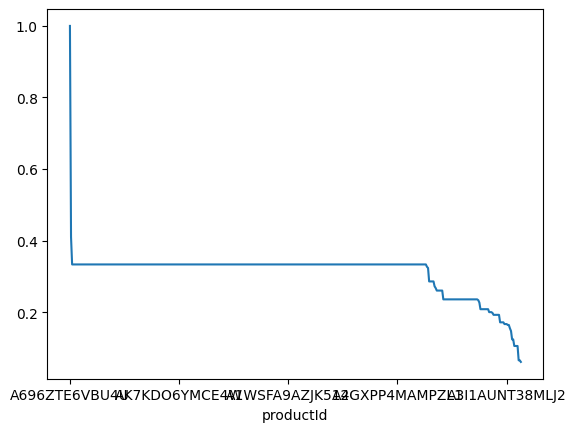

In [104]:
ds['A696ZTE6VBU4U'][ds['A696ZTE6VBU4U'].values>0].sort_values(ascending=False).plot()

In [325]:
dddd

,count
productId,
A2GJX2KCUSR0EI,27
A1KSC91G9AIY2Z,23
A22CW0ZHY3NJH8,21
A1EGCED01USBA9,21
AENH50GW3OKDA,20
...,...
A2BZ7MYTSNYMEW,1
A2BZ6YMTPARCXV,1
A2BZ6FH245B7AV,1


In [117]:
for x in ds.columns:
    # ds[x][ds[x].values>0].sort_values(ascending=False).plot()
    print("\n")
    print(ds[x].sort_values(ascending=False)[0:20])
    print("\n")



productId
A696ZTE6VBU4U     1.000000
AILBHLCU1VM03     0.410305
A2BHNT9FES1RMJ    0.333333
A6LTCHY1GBKOD     0.333333
A3UUDMU2NWGGV8    0.333333
AX4RCYRTHOPNN     0.333333
A1UPPYJ3Y5LZ7C    0.333333
A15W5YMY64KXO8    0.333333
A26CC273TKQQUL    0.333333
ANSIJE0SL1U1Y     0.333333
A2RS3INXDNVVJ3    0.333333
A14I8NKY8202HO    0.333333
A1B4MVUFA0UXD6    0.333333
A1L0X7Y8BL2722    0.333333
A3F7JJXC1QMSGO    0.333333
A3RR0MBI8NLY6H    0.333333
A29I4LM8O92CLC    0.333333
A29VYXPZT8TUFZ    0.333333
ATR2B8OAB4LJS     0.333333
A2FBC63VEW9S7Y    0.333333
Name: A696ZTE6VBU4U, dtype: float64




productId
A35LFTGC7TO48F    1.000000
A3UXFQUZ6P1JRB    1.000000
A2IGYO5UYS44RW    1.000000
A3QDLODOQKUXGN    1.000000
A2A83NR45HQ2OV    1.000000
A165FHUTQU6L2Z    1.000000
A6CEOJ5ISIGRB     1.000000
A28G6HAG3I755Y    1.000000
AHQ9P60N6NOAH     1.000000
A2RWJPXMBFGCF0    1.000000
A26FGQS4JIPDH5    1.000000
AROYPRQ35VSAT     0.912871
AH95EJ2HK06Q2     0.894427
A2U7BI3N4YP26B    0.894427
A12B5Y225ADJWE    0.

In [323]:
df[df.productId.isin(
    ['AFNGCFXDPE55P',
'AILBHLCU1VM03',
'A3Y15MFKAKJR3',
'AOY21F9N2X1QD',
'A1UX6MRX503HNP'])].productId.value_counts()

productId
AFNGCFXDPE55P     6
A3Y15MFKAKJR3     5
A1UX6MRX503HNP    4
AILBHLCU1VM03     3
AOY21F9N2X1QD     3
Name: count, dtype: int64

In [128]:
df = pd.read_csv('eCommerceRatings_wHeader.csv')

In [130]:
df.columns = ['userId', 'productId', 'rating', 'timestamp']

In [134]:
df[df.productId.isin(ds.columns)].productId.value_counts()

productId
A696ZTE6VBU4U     9
A2PUZMHH482FU7    6
A6CEOJ5ISIGRB     6
A2Q2V2KMKOQDI0    4
A2PLGB52VCSYHG    3
Name: count, dtype: int64

In [374]:
pd.DataFrame(df.groupby('userId')['productId'].agg(' '.join))

,productId
userId,
014789302X,A18M3W71X8TYY6 A1NLF2JD7BVOB4 A1X3F9FFDMZ924 A...
097920500X,A13JV4DHJJ12YZ A2O91YORQH16L5 A3R19YKNL641X3
140717455X,A1ZLRH1TEXOBRA AELI4S2UHSI11 ANDPO7R2U9K64
1421694778,A1PN69BSDMSVS8 A2K8CM7Y4AZ557
1421697386,A1AG36LZCXMQ1U AFXP3VWWC1DJ6
...,...
B01HIWLLUK,A22WJD50YSFYCC
B01HJ1K3YK,A31CW6M6DOT894
B01HJ84SGM,A1IYJVHJSCR8DR A1YQHF10YIMWOL A2FZ7C9H14T5HZ A...


In [375]:
pd.DataFrame(df.groupby('userId')['productId'].agg(' '.join))['productId']

userId
014789302X    A18M3W71X8TYY6 A1NLF2JD7BVOB4 A1X3F9FFDMZ924 A...
097920500X         A13JV4DHJJ12YZ A2O91YORQH16L5 A3R19YKNL641X3
140717455X           A1ZLRH1TEXOBRA AELI4S2UHSI11 ANDPO7R2U9K64
1421694778                        A1PN69BSDMSVS8 A2K8CM7Y4AZ557
1421697386                         A1AG36LZCXMQ1U AFXP3VWWC1DJ6
                                    ...                        
B01HIWLLUK                                       A22WJD50YSFYCC
B01HJ1K3YK                                       A31CW6M6DOT894
B01HJ84SGM    A1IYJVHJSCR8DR A1YQHF10YIMWOL A2FZ7C9H14T5HZ A...
B01HJASD20                                       A15UPE8UMHA5KR
B01HJEGTYK    A10NYECANX9N3G A1B5DK6CTP2P24 A1MCGSZ683JMBF A...
Name: productId, Length: 32586, dtype: object

In [385]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()

grouped_df = pd.DataFrame(df.groupby('userId')['productId'].agg(' '.join))['productId']

# Fit the vectorizer to the data and transform it into a TF-IDF matrix
tfidf_matrix = vectorizer.fit_transform(grouped_df)
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out(), index=grouped_df.index)

In [387]:
tfidf_df.columns = tfidf_df.columns.map(str.upper)

In [423]:
tfidf_df.sum()

A0010876CNE3ILIM9HV0    0.125240
A001170867ZBE9FORRQL    0.296649
A0028738FYF1SKPPC7B1    0.065344
A0045356A23634W7RI4M    0.454017
A006277084SDH2LTUV6X    0.015359
                          ...   
AZZW8CF93X1TC           0.098434
AZZWNU4RB5BY1           0.124178
AZZXKG9AGRVGU           0.210935
AZZYW4YOE1B6E           0.068976
AZZZ5UJWUVCYZ           0.351451
Length: 324038, dtype: float64

In [417]:
tfidf_df.T[tfidf_df.loc['B00DGW1SFK'].to_numpy() > 0.0].max(axis=1)

A1KSC91G9AIY2Z    1.000000
A3I3BI5PFL3MSH    0.758175
dtype: float64

In [391]:
df[df['userId']=='B00DGW1SFK']


,userId,productId,rating,timestamp
56320,B00DGW1SFK,A1KSC91G9AIY2Z,3,1391126400
245741,B00DGW1SFK,A3I3BI5PFL3MSH,2,1384992000


<Axes: xlabel='productId'>

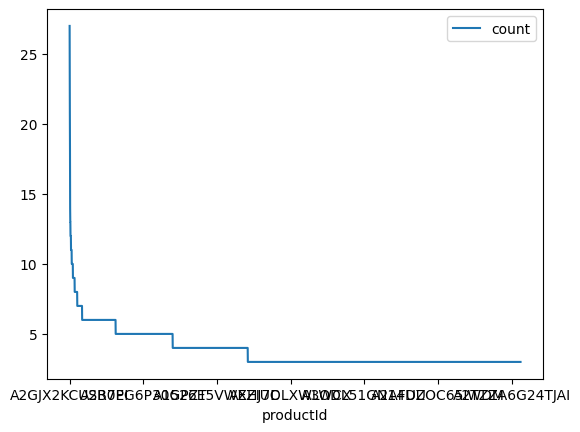

In [173]:
dddd = pd.DataFrame(df.productId.value_counts())
dddd[dddd['count'] > 2].plot()

### Do we wanna weigh products?

In [232]:
np.log(dddd)

,count
productId,
A2GJX2KCUSR0EI,3.295837
A1KSC91G9AIY2Z,3.135494
A22CW0ZHY3NJH8,3.044522
A1EGCED01USBA9,3.044522
AENH50GW3OKDA,2.995732
...,...
A2BZ7MYTSNYMEW,0.000000
A2BZ6YMTPARCXV,0.000000
A2BZ6FH245B7AV,0.000000


In [338]:
ds[ds['A696ZTE6VBU4U'] > 0.0][['A696ZTE6VBU4U', 'counts']].sort_values(by = ['counts', 'A696ZTE6VBU4U'], ascending=False)

,A696ZTE6VBU4U,counts
productId,,
A2WXKLHX5SQC3,0.105409,10
A696ZTE6VBU4U,1.000000,9
AFNGCFXDPE55P,0.272166,6
A3Y15MFKAKJR3,0.197797,5
AOADTSGQ0CULN,0.154746,5
...,...,...
AXF4Z24I585US,0.333333,1
AXUYAFA9UBL7F,0.333333,1
AZC5EBJFOKPXQ,0.333333,1


In [244]:
weighted_by_number_of_customers = ds*np.log(dddd).loc[list(ds.index)].to_numpy()
weighted_by_number_of_customers.columns = [x+"_WEIGHTED" for x in weighted_by_number_of_customers.columns]

In [328]:
ds['counts'] = dddd.loc[list(ds.index)]

In [167]:
weighted_by_number_of_customers

productId
A696ZTE6VBU4U     1.000000
AFNGCFXDPE55P     0.272166
A2WXKLHX5SQC3     0.105409
A2GJX2KCUSR0EI    0.000000
A12X146LZM6KM0    0.000000
                    ...   
A2EHOO31B1KDP4    0.000000
A2EIK3QR1822Q4    0.000000
A3J539P6RXOP9M    0.000000
A2EM4MVIU5Z0KD    0.000000
A165FHUTQU6L2Z    0.000000
Name: A696ZTE6VBU4U, Length: 624, dtype: float64

In [246]:
weighted_by_number_of_customers.columns = [x+"_WEIGHTED" for x in weighted_by_number_of_customers.columns]

In [248]:
new_df = pd.concat([ds, weighted_by_number_of_customers], axis=1)

In [283]:
new_df[['A696ZTE6VBU4U', 'A696ZTE6VBU4U_WEIGHTED']][(new_df['A696ZTE6VBU4U'].to_numpy() > 0.0) | (new_df['A696ZTE6VBU4U_WEIGHTED'].to_numpy()> 0.0)]

,A696ZTE6VBU4U,A696ZTE6VBU4U_WEIGHTED
productId,,
A0748001AYYPDBYVKQOK,0.333333,0.000000
A10U12HAGOSUSP,0.260290,0.180419
A11KOR8XKBLBKM,0.333333,0.000000
A12HMXTJT8P3DS,0.333333,0.000000
A12M8VYMPPPLNE,0.333333,0.000000
...,...,...
AXUYAFA9UBL7F,0.333333,0.000000
AYINCZ8IO1VIF,0.166667,0.231049
AZC5EBJFOKPXQ,0.333333,0.000000


In [284]:
tdf = new_df[['A696ZTE6VBU4U', 'A696ZTE6VBU4U_WEIGHTED']][(new_df['A696ZTE6VBU4U'].to_numpy() > 0.0) | (new_df['A696ZTE6VBU4U_WEIGHTED'].to_numpy()> 0.0)]


In [287]:
ds.to_csv('item-item.csv')

In [298]:
ds

,A696ZTE6VBU4U,A6CEOJ5ISIGRB,A2PLGB52VCSYHG,A2PUZMHH482FU7,A2Q2V2KMKOQDI0
productId,,,,,
A0010876CNE3ILIM9HV0,0.0,0.0,0.0,0.0,0.0
A001170867ZBE9FORRQL,0.0,0.0,0.0,0.0,0.0
A0028738FYF1SKPPC7B1,0.0,0.0,0.0,0.0,0.0
A0045356A23634W7RI4M,0.0,0.0,0.0,0.0,0.0
A006277084SDH2LTUV6X,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...
AZZW8CF93X1TC,0.0,0.0,0.0,0.0,0.0
AZZWNU4RB5BY1,0.0,0.0,0.0,0.0,0.0
AZZXKG9AGRVGU,0.0,0.0,0.0,0.0,0.0


In [313]:
df[df.productId.isin(['AILBHLCU1VM03','A3Y15MFKAKJR3','AOY21F9N2X1QD','A1UX6MRX503HNP'])].value_counts()

userId      productId       rating  timestamp 
B000VV1YOY  A1UX6MRX503HNP  5       1504137600    2
B000142ZFS  A1UX6MRX503HNP  5       1504137600    1
            AOY21F9N2X1QD   3       1514937600    1
B001J9NC56  AOY21F9N2X1QD   2       1510876800    1
B002Q7UCO4  A1UX6MRX503HNP  5       1469923200    1
B0054H0NZ6  AILBHLCU1VM03   4       1477785600    1
B007EITOSK  A3Y15MFKAKJR3   4       1467244800    1
B00N57P3Q6  A3Y15MFKAKJR3   2       1477785600    1
B019Z9JUC0  AILBHLCU1VM03   5       1514419200    1
B019Z9L8PW  A3Y15MFKAKJR3   5       1466121600    1
            AILBHLCU1VM03   5       1514419200    1
B01A50NLXM  A3Y15MFKAKJR3   5       1465344000    1
B01ARMXMI2  A3Y15MFKAKJR3   1       1466467200    1
B01D4LX31E  AOY21F9N2X1QD   1       1489449600    1
Name: count, dtype: int64

In [444]:
ds

,A696ZTE6VBU4U,A6CEOJ5ISIGRB,A2PLGB52VCSYHG,A2PUZMHH482FU7,A2Q2V2KMKOQDI0,counts
productId,,,,,,
A0010876CNE3ILIM9HV0,0.0,0.0,0.0,0.0,0.0,1
A001170867ZBE9FORRQL,0.0,0.0,0.0,0.0,0.0,2
A0028738FYF1SKPPC7B1,0.0,0.0,0.0,0.0,0.0,1
A0045356A23634W7RI4M,0.0,0.0,0.0,0.0,0.0,1
A006277084SDH2LTUV6X,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...
AZZW8CF93X1TC,0.0,0.0,0.0,0.0,0.0,1
AZZWNU4RB5BY1,0.0,0.0,0.0,0.0,0.0,1
AZZXKG9AGRVGU,0.0,0.0,0.0,0.0,0.0,1


In [475]:
# 'A696ZTE6VBU4U'
# Users who purchased x, also purchased
def grab_ten_most_popular_products_based_on_users_purchases(product_id):
    # neutral is ok in this instance, we wanna see what others have bough who bought this and are satisfied.
    user_who_bought_and_rated_high = df[(df['productId'] == product_id) & (df['rating'] >= 3)]['userId'].unique()

    # get all the products associated with those users (let's say top 10)
    # boost rating of given products by ...
    # log(count*(rating/5))? rating normalizes the count, the lower the rating, the less the count matters...
    print(df[(df['userId'].isin(user_who_bought_and_rated_high)) & (df.rating >= 4)].groupby('productId')[['productId', 'rating']].value_counts().reset_index().sort_values(by=['count','rating'], ascending=False)[:10])

In [473]:
hybrid_approach('A696ZTE6VBU4U')

                productId  rating  count
247         A696ZTE6VBU4U       5      9
261         AFNGCFXDPE55P       5      2
270         AILBHLCU1VM03       5      2
0    A0748001AYYPDBYVKQOK       5      1
1          A10U12HAGOSUSP       5      1


In [344]:
for x in ds.columns:
    if x=='counts':
        continue
    # ds[x][ds[x].values>0].sort_values(ascending=False).plot()
    print("\n")
    # tdf = new_df[[x, x+'_WEIGHTED']][(new_df[x].to_numpy() > 0.0) | (new_df[x + '_WEIGHTED'].to_numpy()> 0.0)]
    print(ds[[x,'counts']].sort_values(by=[x, 'counts'], ascending=False)[0:10])
    # print(tdf.sort_values(by=[x+'_WEIGHTED', x], ascending=False)[0:10])
    # print(weighted_by_number_of_customers[ds.columns.mx].sort_values(ascending=False)[0:20])
    print("\n")



                      A696ZTE6VBU4U  counts
productId                                  
A696ZTE6VBU4U              1.000000       9
AILBHLCU1VM03              0.410305       3
A0748001AYYPDBYVKQOK       0.333333       1
A11KOR8XKBLBKM             0.333333       1
A12HMXTJT8P3DS             0.333333       1
A12M8VYMPPPLNE             0.333333       1
A1398JZNNGBJIM             0.333333       1
A13Z4IY37VXLP2             0.333333       1
A148PN09M9WCQM             0.333333       1
A14FBPCCI1YX7M             0.333333       1




                A6CEOJ5ISIGRB  counts
productId                            
A165FHUTQU6L2Z            1.0       6
A26FGQS4JIPDH5            1.0       6
A28G6HAG3I755Y            1.0       6
A2A83NR45HQ2OV            1.0       6
A2IGYO5UYS44RW            1.0       6
A2RWJPXMBFGCF0            1.0       6
A35LFTGC7TO48F            1.0       6
A3QDLODOQKUXGN            1.0       6
A3UXFQUZ6P1JRB            1.0       6
A6CEOJ5ISIGRB             1.0       6




      